(bivariate-beta)=
# Constructions for a bivariate beta distribution

This construction is a reproduction of {cite:t}`olkin2015constructions`. The
ideia is to define a probability distribution over $[0,1] \times [0,1]$ such
that the marginals are beta distributions with correlation varying between -1
and 1. There are other ways to do it, but the advantage of this one is its
simplicity. 

Let $U = (U_1, U_2, U_3, U_4) \sim \operatorname{Dirichlet}(\boldsymbol{\alpha})$, where $\boldsymbol{\alpha} =
(\alpha_1, \alpha_2, \alpha_3, \alpha_4)$ with $\alpha_i > 0, i = 1,\dots,4$
and $U_4 = 1 - U_1 + U_2 + U_3$. The joint density of $U$ with respect to the
Lebesgue measure is given by

\begin{equation}
  f_U(u_1, u_2, u_3) = \frac{1}{B(\boldsymbol{\alpha})}u_1^{\alpha_1-1}u_2^{\alpha_2-1}u_3^{\alpha_3-1}(1-u_1-u_2-u_3)^{\alpha_4-1}, 
\end{equation}

when $u_i \in [0,1], i = 1,2,3$, $u_1 + u_2 + u_3 \le 1$, and $0$ otherwise.
The normalizing constant is 

$$B(v) = \frac{\prod_{i=1}^n \Gamma(v_i)}{\Gamma\left(\sum_{i=1}^n
v_i\right)},$$

for $v \in \mathbb{R}^n$.


Let 

\begin{equation}
X = U_1 + U_2 \text{ and } Y = U_1 + U_3.
\end{equation} 

**Definition:** The distribution of $(X,Y)$ is *Bivariate Beta* with parameters
$\boldsymbol{\alpha}$.  the marginal distribution of $X$ is Beta with
parameters $\alpha_1 + \alpha_2$ and $\alpha_3 + \alpha_4$. Similarly, the
marginal distribution of $Y$ is Beta with parameters $\alpha_1 + \alpha_3$ and
$\alpha_2 + \alpha_4$.

Remarks: 

- Non closed form; 
- Density symmetric in $(x, \alpha_{10})$ and $(y, \alpha_{01})$. 


In [1]:
%matplotlib inline

import numpy as np
from scipy.special import gamma
from scipy.integrate import quad
from scipy.stats import beta

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm.notebook import tqdm
from time import time

## Marginal distributions 

The first thing we have to verify is that the marginal distributions are
*really* beta distributions. It is only a sanity check, since this was proved
in the dissertation. 

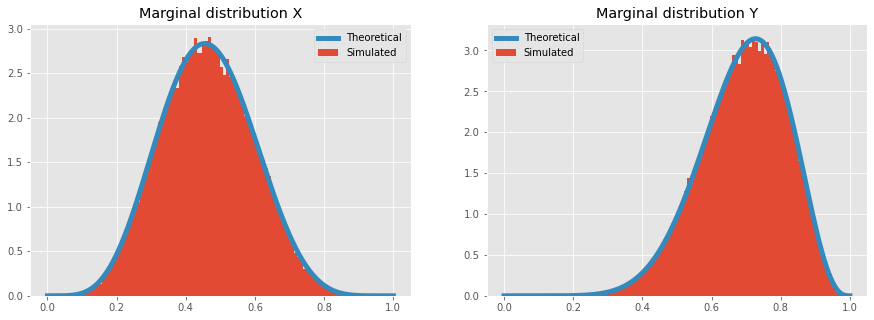

In [159]:
alpha = np.array([4,2,5,2])
# Generating Dirichlet
U = np.random.dirichlet(alpha, size = 100000)
# Calculating X and Y
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]

fig, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].hist(X, 100, density = True, label = 'Simulated')
ax[1].hist(Y, 100, density = True, label = 'Simulated')

t = np.linspace(0,1,1000)
ax[0].plot(t, beta(a = alpha[0] + alpha[1], b = alpha[2] + alpha[3]).pdf(t), linewidth = 5, label = 'Theoretical')
ax[1].plot(t, beta(a = alpha[0] + alpha[2], b = alpha[1] + alpha[3]).pdf(t), linewidth = 5, label = 'Theoretical')

ax[0].legend()
ax[1].legend()
ax[0].set_title('Marginal distribution X')
ax[1].set_title('Marginal distribution Y')
plt.show()


We can also compare the predicted correlation with the simulated one. Notice
that they are quite similar, which indicates the sanity in our accounts. 

In [3]:
print('The simulated correlation between X and Y is {}'.format(np.corrcoef(X,Y)[0,1]))
theoretical = (alpha[0]*alpha[3] - alpha[1]*alpha[2]) 
theoretical /= np.sqrt((alpha[0]+alpha[1])*(alpha[0]+alpha[2])*(alpha[3]+alpha[1])*(alpha[3]+alpha[2]))
print('The theoretical correlation between X and Y is {}'.format(theoretical))

The simulated correlation between X and Y is -0.04644077461142311
The theoretical correlation between X and Y is -0.05143444998736397


## The joint density

We now write the function as described in the article. 

In [145]:
gen_beta = lambda alpha: gamma(alpha).prod()/gamma(alpha.sum())

def f_u_exp_log(u, x, y, alpha):
    
    log_fun  = (alpha[0]-1)*np.log(u)
    log_fun += (alpha[1]-1)*np.log(x-u)
    log_fun += (alpha[2]-1)*np.log(y-u)
    log_fun += (alpha[3]-1)*np.log1p(-x-y+u)
    
    return np.exp(log_fun)

def f_u(u, x, y, alpha): 
    
    if (u == 0) or (u == x) or (u == y) or (u == x+y-1): 
        return 0
    
    fun  = u**(alpha[0]-1)
    fun *= (x-u)**(alpha[1]-1)
    fun *= (y-u)**(alpha[2]-1)
    fun *= (1-x-y+u)**(alpha[3]-1)
    
    return fun


def bivariate_beta_pdf(x,y,alpha, func): 

    # In order to handle integration problems explained below
    if alpha[0] + alpha[3] <= 1: 
        if abs(x + y - 1) <= 1e-7: return [0,0]
    if alpha[1] + alpha[2] <= 1:
        if abs(x - y) <= 1e-7: return [0,0]
    
    if x <= 1e-7 or y <= 1e-7: return [0,0]
    if 1-x <= 1e-7 or 1-y <= 1e-7: return [0,0]
    
    c = gen_beta(alpha)
    
    lb = max(0,x+y-1)
    ub = min(x,y)
    result = quad(func, lb, ub, args = (x,y,alpha), epsabs=1e-10, limit=50)/c
            
    return result

We chose the following set of $\alpha$ vectors to compare the distributions. 

In [146]:
alphas = np.array([[1,1,1,1], 
                   [10,10,10,10],
                   [.5,.5,.5,.5],
                   [.25,.25,.25,.25],
                   [8,2,2,2],
                   [2,8,2,2],
                   [2,2,8,2],
                   [2,2,2,8],
                   [5,2,5,1],
                   [8,1,1,8],
                   [1,8,8,1],
                   [1,1,1,0.25],
                 ])

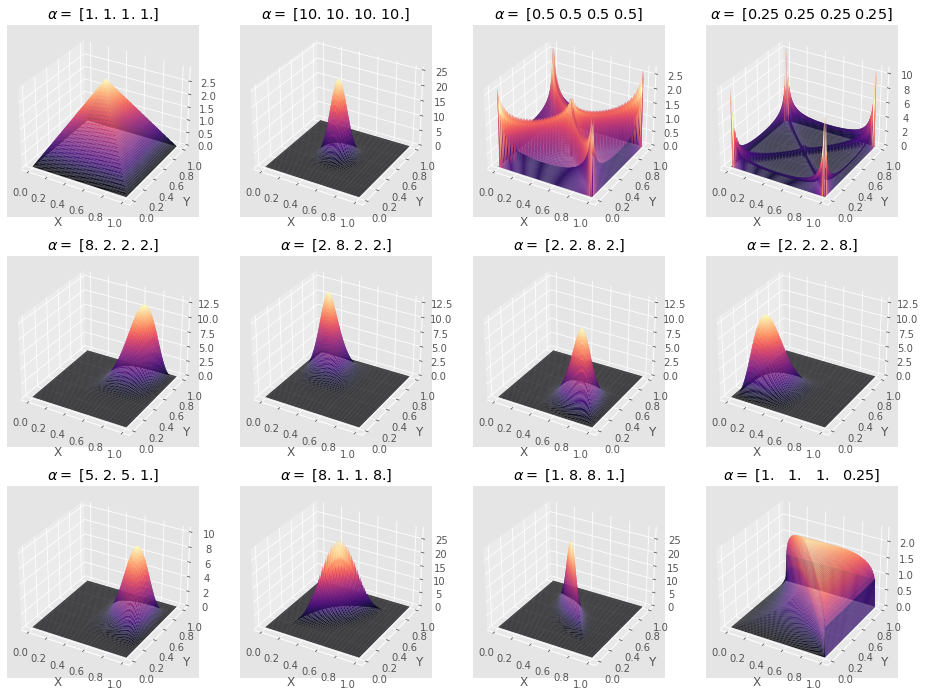

In [149]:
x_values = y_values = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_values,y_values)

fig = plt.figure(figsize = (16, 12))

Z = np.zeros_like(X)

for k, alpha in enumerate(alphas):
    
    for i,x in enumerate(x_values): 
        for j,y in enumerate(y_values): 
            Z[i,j] = bivariate_beta_pdf(x, y, alpha, f_u)[0]
    
    ax = fig.add_subplot(3, 4, k+1, projection='3d') 
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='magma', edgecolor='none')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y');
    ax.set_title(r"$\alpha =$ {}".format(alpha));

plt.savefig('../images/joint-densities-bivariate-beta.pdf', bbox_inches = 'tight')

### Integration problems

Here we present only an example with integration problems. For more details,
consult the dissertation text. Set $\alpha = (0.5,0.5,0.5,0.5)$ and $x = y < 0.5$. In this case 

$$
\begin{split}
    f(x,y) &= \int_0^x u^{-0.5}(x - u)^{-0.5}(y - u)^{-0.5}(1-x-y+u)^{-0.5} du  \\
    &= \int_0^x u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du \\
    &= \int_0^{x/2} u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du + \int_{x/2}^x u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du \\
    &= \int_0^{x/2} u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du + \int_{x/2}^x u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du \\
    &\ge \int_0^{x/2} u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du + \int_{x/2}^x x^{-0.5}(x - u)^{-1}(1-x)^{-0.5} du \\
    &= \int_0^{x/2} u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du + x^{-0.5}(1-x)^{-0.5}\int_0^{x/2} \frac{1}{v} dv \\
    &\ge x^{-0.5}(1-x)^{-0.5}\lim_{t\to 0} \left(\log(x/2) - \log(t)\right) = +\infty .\\
\end{split}
$$

Care must be taken when choosing the parameters, especially when all are smaller than one. In special, if $\alpha_{10} = \alpha_{01} \le 0.5$ and $x = y$, the integral diverges.

(moments-summary)=
## Moments summary 

These moments can be calculated from the expressions from $X$ and $Y$. We have
that

\begin{align*}
    X &\sim \operatorname{Beta}(\alpha_1 + \alpha_2, \alpha_3 + \alpha_4) \\
    Y &\sim \operatorname{Beta}(\alpha_1 + \alpha_3, \alpha_2 + \alpha_4) \\
    \operatorname{E}(X) &= \operatorname{E}(U_1 + U_2) = \frac{\alpha_1+\alpha_2}{\alpha_1+\alpha_2+\alpha_3+\alpha_4} \\
    \operatorname{E}(Y) &= \operatorname{E}(U_1 + U_3) = \frac{\alpha_1+\alpha_3}{\alpha_1+\alpha_2+\alpha_3+\alpha_4} \\
    \operatorname{Var}(X) &= \operatorname{Cov}(U_1+U_2, U_1+U_2) = \frac{1}{\tilde{\alpha}^2(\tilde{\alpha}+1)}(\alpha_1+\alpha_2)(\alpha_3 + \alpha_4) \\
    \operatorname{Var}(Y) &= \operatorname{Cov}(U_1+U_3, U_1+U_3) = \frac{1}{\tilde{\alpha}^2(\tilde{\alpha}+1)}(\alpha_1+\alpha_3)(\alpha_2 + \alpha_4)  \\ 
    \operatorname{Cor}(X,Y) &= \frac{\operatorname{Cov}(X,Y)}{\sqrt{\operatorname{Var}(X)\operatorname{Var}(Y)}} = \frac{\alpha_1\alpha_4 - \alpha_2\alpha_3}{\sqrt{(\alpha_1+\alpha_2)(\alpha_3+\alpha_4)(\alpha_1+\alpha_3)(\alpha_2+\alpha_4)}}
\end{align*}